# 11.2 凸性
- **目录**
  - 11.2.1 凸优化相关概念
    - 11.2.1.1 凸集
    - 11.2.1.2 凸函数
    - 11.2.1.3 詹森不等式
  - 11.2.2 凸函数的性质
    - 11.2.2.1 局部极小值是全局极小值
    - 11.2.2.2 凸函数的下水平集是凸的
    - 11.2.2.3 凸性和二阶导数
  - 11.2.3 凸优化的约束
    - 11.2.3.1 拉格朗日函数
    - 11.2.3.2 惩罚
    - 11.2.3.3 投影

- <b>凸性（convexity）</b>在优化算法的设计中起到至关重要的作用，
这主要是由于在这种情况下对算法进行分析和测试要容易得多。
- 换言之，如果该算法甚至在凸性条件设定下的效果很差，
通常我们很难在其他条件下看到好的结果。
- 此外，即使深度学习中的优化问题通常是非凸的，
它们也经常在局部极小值附近表现出一些凸性。
- 凸优化领域的经典教材是Stephen Boyd的《凸优化》（Convex Optimization），可以仔细研读，尤其是拉格朗日对偶理论非常重要。

- **凸优化教材**
  
<img src='../img/11_2_1.png' width=400px />

In [1]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

## 11.2.1 凸优化相关概念

在进行凸分析之前，我们需要定义**凸集（convex sets）**和**凸函数（convex functions）**。

### 11.2.1.1 凸集

**凸集（convex set）** 是凸性的基础。
简单地说，如果对于任何$a，b \in \mathcal{X}$，连接$a$和$b$的线段也位于$\mathcal{X}$中，则向量空间中的一个集合$\mathcal{X}$是**凸（convex）** 的。
在数学术语上，这意味着对于所有$\lambda \in [0, 1]$，我们得到

$$\lambda  a + (1-\lambda)  b \in \mathcal{X} \text{ 当 } a, b \in \mathcal{X} \tag{11.2.1}$$

这听起来有点抽象，那我们来看一下图11.2.1里的例子。
第一组存在不包含在集合内部的线段，所以该集合是非凸的，而另外两组则没有这样的问题。

<center><img src='../img/pacman.svg'/></center>
<center>图11.2.1 第一组是非凸的，另外两组是凸的</center><br>
有了定义做什么呢？
我们来看一下交集 图11.2.2。
假设$\mathcal{X}$和$\mathcal{Y}$是凸集，那么$\mathcal {X} \cap \mathcal{Y}$也是凸集的。
现在考虑任意$a, b \in \mathcal{X} \cap \mathcal{Y}$，
因为$\mathcal{X}$和$\mathcal{Y}$是凸集，
所以连接$a$和$b$的线段包含在$\mathcal{X}$和$\mathcal{Y}$中。
鉴于此，它们也需要包含在$\mathcal {X} \cap \mathcal{Y}$中，从而证明我们的定理。

<center><img src='../img/convex-intersect.svg'/></center>
<center>图11.2.2 两个凸集的交集是凸的</center><br>

我们可以毫不费力地进一步得到这样的结果：
给定凸集$\mathcal{X}_i$，它们的交集$\cap_{i} \mathcal{X}_i$是凸的。
但是反向是不正确的，考虑两个不相交的集合$\mathcal{X} \cap \mathcal{Y} = \emptyset$，
取$a \in \mathcal{X}$和$b \in \mathcal{Y}$。
因为我们假设$\mathcal{X} \cap \mathcal{Y} = \emptyset$，
在 图11.2.3中连接$a$和$b$的线段需要包含一部分既不在$\mathcal{X}$也不在$\mathcal{Y}$中。
因此线段也不在$\mathcal{X} \cup \mathcal{Y}$中，因此证明了凸集的并集不一定是凸的，即**非凸（nonconvex）** 的。

<center><img src='../img/nonconvex.svg'/></center>
<center>图11.2.3 两个凸集的并集不一定是凸的</center><br>

通常，深度学习中的问题是在凸集上定义的。
例如，$\mathbb{R}^d$，即实数的$d$-维向量的集合是凸集（毕竟$\mathbb{R}^d$中任意两点之间的线存在$\mathbb{R}^d$）中。
在某些情况下，我们使用有界长度的变量，例如球的半径定义为$\{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ and } \| \mathbf{x} \| \leq r\}$。

- **要点：**
  - 凸集（Convex Set）：如果一个集合中的任意两点所连成的线段都位于该集合内，那么我们就称这个集合为凸集。
  - 交集的凸性：如果两个集合都是凸集，那么这两个凸集的交集也是凸集。换句话说，两个凸集的交集仍然保持凸性。
  - 并集的凸性：但是两个凸集的并集可能不是凸集。也就是说，并集可能会破坏凸性，这就可能产生非凸集。
  - 深度学习中的凸集：在深度学习中，我们通常会处理在凸集上定义的问题，例如实数的d维向量的集合。有时，我们也会使用有界长度的变量，例如以原点为中心，半径为r的球形空间。

### 11.2.1.2 凸函数

现在我们有了凸集，我们可以引入**凸函数（convex function）$f$。**
给定一个凸集$\mathcal{X}$，如果对于所有$x, x' \in \mathcal{X}$和所有$\lambda \in [0, 1]$，一个函数$f: \mathcal{X} \to \mathbb{R}$是凸的，我们可以得到

$$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x') \tag{11.2.2}$$

为了说明这一点，让我们绘制一些函数并检查哪些函数满足要求。
下面我们定义一些函数，包括凸函数和非凸函数。

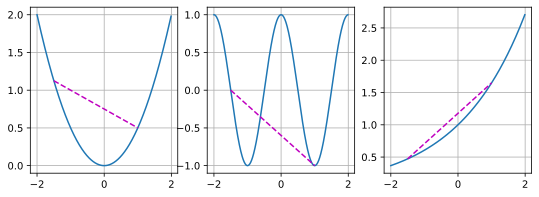

In [2]:
f = lambda x: 0.5 * x**2  # 凸函数
g = lambda x: torch.cos(np.pi * x)  # 非凸函数
h = lambda x: torch.exp(0.5 * x)  # 凸函数

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

不出所料，余弦函数为非凸的，而抛物线函数和指数函数为凸的。
请注意，为使该条件有意义，$\mathcal{X}$是凸集的要求是必要的。
否则可能无法很好地界定$f(\lambda x + (1-\lambda) x')$的结果。

### 11.2.1.3 詹森不等式

给定一个凸函数$f$，最有用的数学工具之一就是**詹森不等式（Jensen's inequality）**。
它是凸性定义的一种推广：

$$\sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right) \text{ and } E_X[f(X)] \geq f\left(E_X[X]\right) \tag{11.2.3}$$


其中$\alpha_i$是满足$\sum_i \alpha_i = 1$的非负实数，$X$是随机变量。
换句话说，**凸函数的期望不小于期望的凸函数**，其中后者通常是一个更简单的表达式。
为了证明第一个不等式，我们多次将凸性的定义应用于一次求和中的一项。

詹森不等式的一个常见应用：用一个较简单的表达式约束一个较复杂的表达式。
例如，它可以应用于部分观察到的随机变量的对数似然。
具体地说，由于$\int P(Y) P(X \mid Y) dY = P(X)$，所以

$$E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log P(X)  \tag{11.2.4} $$

这里，$Y$是典型的未观察到的随机变量，$P(Y)$是它可能如何分布的最佳猜测，$P(X)$是将$Y$积分后的分布。
例如，在聚类中$Y$可能是簇标签，而在应用簇标签时，$P(X \mid Y)$是生成模型。

---------------
- **说明：公式11.2.3和公式11.2.4的详细解析**
  - **(1) 公式11.2.3：**
    - 这是詹森不等式的一个版本。该不等式基于一个事实，即对于凸函数$f$，其在集合上的期望值大于或等于函数在集合期望值点上的值。这在形式上可以表示为：$\sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right)$。这里，$\alpha_i$是非负实数，满足$\sum_i \alpha_i = 1$，代表了一个加权平均或期望。不等式的另一种形式是：$E_X[f(X)] \geq f\left(E_X[X]\right)$，这是在概率论中常用的形式，表示**随机变量$X$在函数$f$下的期望大于等于函数$f$在$X$的期望处的值**。
    - 例如，假设有一个随机变量$X$，它在$1$，$2$，$3$这三个数上均匀分布，即每个数的概率都是$1/3$，我们要计算这个随机变量在函数$f(x)=x^2$下的期望。如果直接计算，即$E[f(X)] = (1/3) * 1^2 + (1/3) * 2^2 + (1/3) * 3^2 = 14/3 ≈ 4.67$。如果先计算X的期望，再将期望带入函数$f$，即$f(E[X]) = f[(1/3) * 1 + (1/3) * 2 + (1/3) * 3] = f[2] = 4$。根据詹森不等式，$E[f(X)] >= f(E[X])$，在这个例子中，$4.67 >= 4$，满足詹森不等式。
  - **(2) 公式11.2.4：**
    - 该公式是詹森不等式在概率论中的一种应用，经常用于**对数似然的上下界**进行**约束**。
    - $E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log (E_{Y \sim P(Y)}[P(X \mid Y)]) = -\log P(X) $
    - 即推导：$E_{Y \sim P(Y)}[P(X \mid Y)] = P(X) $
    - 假设 $ X $ 和 $ Y $ 是离散随机变量。
    - 定义条件概率:
        $$
        P(X|Y = y) = \frac{P(X = x, Y = y)}{P(Y = y)}, \quad \text{当 $ P(Y = y) > 0 $}.
        $$
    - 条件期望的定义。 对 $ P(X|Y) $ 取期望：
        $$
        E[P(X|Y)] = \sum_y P(X|Y = y) \cdot P(Y = y),
        $$
        这里 $ P(Y = y) $ 是 $ Y $ 的边缘概率分布。
    - 代入条件概率的定义。 将 $ P(X|Y = y) = \frac{P(X = x, Y = y)}{P(Y = y)} $ 代入上式：
      $$
      E[P(X|Y)] = \sum_y \frac{P(X = x, Y = y)}{P(Y = y)} \cdot P(Y = y).
      $$
    - 化简。注意 $ P(Y = y) $ 出现在分子和分母中，可以相互抵消：
      $$
      E[P(X|Y)] = \sum_y P(X = x, Y = y).
      $$
    - 联合分布的性质。联合概率 $ P(X = x, Y = y) $ 的边缘化性质：
      $$
      \sum_y P(X = x, Y = y) = P(X = x).
      $$
    - 根据詹森不等式，知道这个期望大于等于$-log P(X)$，其中$P(X)$是$X$的真实分布。
      - 如果设计的模型较优，即$P(X|Y)$接近$P(X)$，那么上述两项应该很接近。
      - 如果模型设计低劣，那么$-log P(X|Y)$的期望会明显大于$-log P(X)$。
      - 可以通过计算这两项来评估模型的性能。
-----------------

## 11.2.2 凸函数的性质

下面我们来看一下凸函数一些有趣的性质。

### 11.2.2.1 局部极小值是全局极小值

首先凸函数的局部极小值也是全局极小值。
下面我们用**反证法**给出证明。

假设$x^{\ast} \in \mathcal{X}$是一个局部最小值，则存在一个很小的正值$p$，使得当$x \in \mathcal{X}$满足$0 < |x - x^{\ast}| \leq p$时，有$f(x^{\ast}) < f(x)$。

现在假设局部极小值$x^{\ast}$不是$f$的全局极小值：存在$x' \in \mathcal{X}$使得$f(x') < f(x^{\ast})$。
则存在
$\lambda \in [0, 1)$，比如$\lambda = 1 - \frac{p}{|x^{\ast} - x'|}$，使得
$0 < |\lambda x^{\ast} + (1-\lambda) x' - x^{\ast}| \leq p$。

然而，根据凸性的性质，有

$$\begin{aligned}
    f(\lambda x^{\ast} + (1-\lambda) x') &\leq \lambda f(x^{\ast}) + (1-\lambda) f(x') \\
    &< \lambda f(x^{\ast}) + (1-\lambda) f(x^{\ast}) \\
    &= f(x^{\ast}), \\
\end{aligned} \tag{11.2.5}$$

这与$x^{\ast}$是局部最小值相矛盾。
因此，不存在$x' \in \mathcal{X}$满足$f(x') < f(x^{\ast})$。
综上所述，局部最小值$x^{\ast}$也是全局最小值。

例如，**对于凸函数$f(x) = (x-1)^2$，有一个局部最小值$x=1$，它也是全局最小值。**

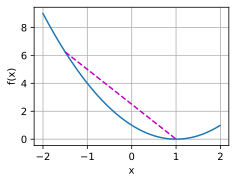

In [3]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

凸函数的局部极小值同时也是全局极小值这一性质是很方便的。
这意味着如果我们最小化函数，我们就不会“卡住”。
但是，请注意，**这并不意味着不能有多个全局最小值，或者可能不存在一个全局最小值**。
例如，函数$f(x) = \mathrm{max}(|x|-1, 0)$在$[-1,1]$区间上都是最小值。
相反，函数$f(x) = \exp(x)$在$\mathbb{R}$上没有取得最小值。对于$x \to -\infty$，它趋近于$0$，但是没有$f(x) = 0$的$x$。

---------
- **说明：如何理解“局部极小值是全局极小值”？**
  - 局部极小值最普通的情况就是某点的函数局部极小值左右附近点的函数值都小，对于凸函数只有一处最小值就是全局最小值，比如下图（1）。
  - 如果局部极小值右边没有定义域，左边点的值大于等于该点的值，该点的函数值也是全局极小值，比如图（2）。
  - 如果局部极小值左边没有定义域，那么右边的函数值也是大于或等于该点的函数值，该点的函数值也是全局极小值，比如图（3）。
  - 全局最小值可能不止一个，比如图（4）。
----------

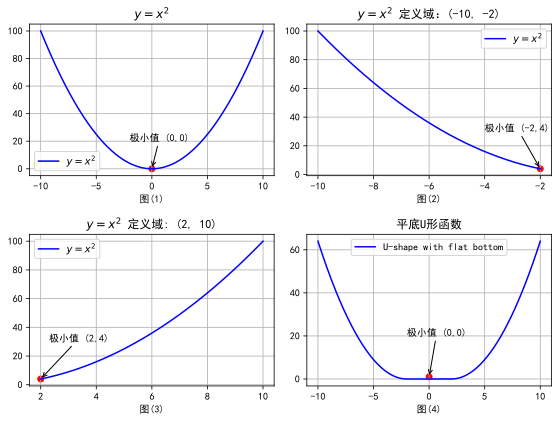

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# 设置matplotlib库可以显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# "代码1" - y = x^2
x_vals = np.linspace(-10, 10, 400)

# 计算函数y = x^2的值
y_vals = x_vals**2

axes[0, 0].plot(x_vals, y_vals, label='$y = x^2$', color='blue')
min_point_original = (0, 0)
axes[0, 0].scatter(*min_point_original, color='red')
axes[0, 0].annotate('极小值 (0,0)', xy=min_point_original, xytext=(-2, 20), 
                    arrowprops=dict(facecolor='black', arrowstyle='->'),
                    fontsize=10, color='black')
axes[0, 0].set_title('$y = x^2$')
axes[0, 0].grid(True)
axes[0, 0].legend()
axes[0, 0].set_xlabel('图(1)')

# "代码2" - y = x^2 在定义 (-10, -2) 有一个极小值点
x_vals_domain = np.linspace(-10, -2, 400)
# Compute y values for the function y = x^2 within the specified domain
y_vals_domain = x_vals_domain**2
axes[0, 1].plot(x_vals_domain, y_vals_domain, label='$y = x^2$', color='blue')
min_point_domain = (-2, 4)
axes[0, 1].scatter(*min_point_domain, color='red')
axes[0, 1].annotate('极小值 (-2,4)', xy=min_point_domain, xytext=(-4, 30), 
                    arrowprops=dict(facecolor='black', arrowstyle='->'),
                    fontsize=10, color='black')
axes[0, 1].set_title('$y = x^2$ 定义域：(-10, -2)')
axes[0, 1].grid(True)
axes[0, 1].legend()
axes[0, 1].set_xlabel('图(2)')

# "代码3" - y = x^2 在定义域 (2, 10)上有一个极小值点
x_vals_domain_2 = np.linspace(2, 10, 400)


#给定定义域，计算函数 y = x^2的值
y_vals_domain_2 = x_vals_domain_2**2
axes[1, 0].plot(x_vals_domain_2, y_vals_domain_2, label='$y = x^2$', color='blue')
min_point_domain_2 = (2, 4)
axes[1, 0].scatter(*min_point_domain_2, color='red')
axes[1, 0].annotate('极小值 (2,4)', xy=min_point_domain_2, xytext=(2.3, 30), 
                    arrowprops=dict(facecolor='black', arrowstyle='->'),
                    fontsize=10, color='black')
axes[1, 0].set_title('$y = x^2$ 定义域: (2, 10)')
axes[1, 0].grid(True)
axes[1, 0].legend()
axes[1, 0].set_xlabel('图(3)')

# "代码4"：平底U形函数
def u_shape_flat_bottom(x, width=2, depth=0):
    return np.where(np.abs(x) < width, 0, (np.abs(x) - width)**2 + depth)

y_vals_u_flat = u_shape_flat_bottom(x_vals, width=2, depth=0)
axes[1, 1].plot(x_vals, y_vals_u_flat, label='U-shape with flat bottom', color='blue')
min_point_u_flat = (0, 1)
axes[1, 1].scatter(*min_point_u_flat, color='red')
axes[1, 1].annotate('极小值 (0,0)', xy=min_point_u_flat, xytext=(-2, 20), 
                    arrowprops=dict(facecolor='black', arrowstyle='->'),
                    fontsize=10, color='black')
axes[1, 1].set_title('平底U形函数')
axes[1, 1].grid(True)
axes[1, 1].legend()
axes[1, 1].set_xlabel('图(4)')
plt.tight_layout()
plt.show()


- **为何不直接说凸函数的全局最小值，而是借助局部最小值引出全局最小值？**
  - 凸函数不一定有全局最小值。
    - 凸函数是否有全局最小值取决于定义域和函数本身的性质。
    - 例如，如果定义域是无限的，或者函数没有下界，就可能不存在全局最小值。
    - 因此，不能直接笼统地说“凸函数一定有全局最小值”。
  - 局部极小值到全局极小值的性质更为普适。
    - 凸函数的核心性质是“局部极小值就是全局极小值”，这在凸优化中非常有用，因为它使得优化问题可以通过寻找局部极小值来解决全局问题。
    - 如果直接去证明全局最小值的存在，可能需要额外的假设（如定义域是紧的，函数是下有界的等）。
    - 如只要知道某点是局部极小值，优化算法就可以立即断定其是全局极小值，而不需要额外假设。
  - 数学表述的精确性。
    - 数学上的表述通常强调性质的逻辑链条和适用范围。
    - 凸函数的定义本身并不保证全局最小值的存在，但**保证局部极小值与全局极小值的一致性**。
    - 这一性质独立于其他条件（如定义域的紧性）而存在，因此更为**普适**。
  - 优化问题中的实际意义。
    - 在优化问题通常关心的是如何找到全局最小值。
    - 对于凸函数，由于“局部极小值就是全局极小值”，这意味着：
      - 只需要关注局部极小值的寻找，尤其是在数值优化中（如梯度下降法），这大大降低了问题的复杂性。
      - 可以忽略全局搜索的复杂过程，而仅仅关注函数的局部行为（例如一阶导数是否为 0，或者梯度是否消失），这在高维优化问题中尤为重要。
      - 如果直接说“凸函数有全局最小值”，它忽略了这个性质的重要性，因此在凸优化领域，强调“局部极小值即全局极小值”更有实际意义。
-------------


### 11.2.2.2 凸函数的下水平集是凸的

我们可以方便地通过凸函数的**下水平集（below sets）** 定义凸集。
具体来说，给定一个定义在凸集$\mathcal{X}$上的凸函数$f$，其**任意一个**下水平集

$$\mathcal{S}_b := \{x | x \in \mathcal{X} \text{ and } f(x) \leq b\} \tag{11.2.6} $$

是凸的。（**注**：$\mathcal{S}_b $ 是输入集合中所有使得 $ f(x) \leq b $ 成立的点 $ x $ 的集合）。

让我们快速证明一下。
对于任何$x, x' \in \mathcal{S}_b$，我们需要证明：当$\lambda \in [0, 1]$时，$\lambda x + (1-\lambda) x' \in \mathcal{S}_b$。
因为$f(x) \leq b$且$f(x') \leq b$，所以

$$f(\lambda x + (1-\lambda) x') \leq \lambda f(x) + (1-\lambda) f(x') \leq b \tag{11.2.7}$$

----------
- **说明：下水平集，凸函数的下水平集是凸的可视化**
  - 下水平集（below sets）是凸分析中的一个重要概念。对于给定的函数 $ f $，其下水平集表示函数值小于或等于某个常数$ b $的所有输入的集合。
  - 简单来说，下水平集就是函数图像以下区域的投影。
  - 为了更直观地理解下水平集，考虑一个简单的一维例子：
    - 考虑函数 $f(x) = x^2$。如果选择$b = 1$，则下水平集是$\mathcal{S}_1 = \{ x | x^2 \leq 1 \}$
    - 这意味着$x$ 的取值范围是$[-1, 1]$。
    - 在图形上看，这就是**抛物线$y = x^2$ 以下部分与直线 $y = 1$ 之间的区域在$x$-轴上的投影**。
  - 如果再考虑二维空间中的函数$f(x, y) = x^2 + y^2$，并选择$b = 1$，则下水平集是单位圆，即圆心在原点、半径为1的圆内部的所有点。
  -  水平集提供了一个通过观察函数的“等高线”来确定其凸性的方法。
  -  **如果函数的每一个下水平集都是凸的，那么该函数是凸函数**。这是凸函数的一个非常有用的性质。
  - 如下图：
    - 下水平集是函数值小于或等于$1$的区域，即蓝色的部分。
    - 此外还绘制了等于$1$的**等高线**，以显示下水平集的边界。

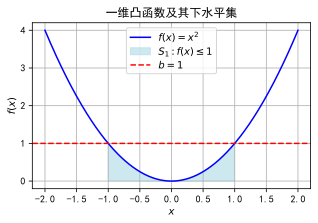

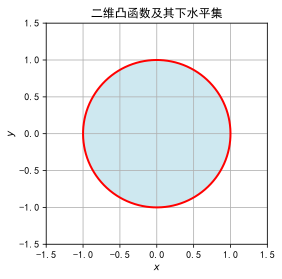

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# 设置matplotlib库可以显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# 一维函数 f(x) = x^2 的下水平集
def plot_1d_level_set():
    x = np.linspace(-2, 2, 400)
    y = x**2
    
    # 下水平集：f(x) <= 1
    level_set_x = np.linspace(-1, 1, 200)
    level_set_y = level_set_x**2
    
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, label='$f(x) = x^2$', color='blue')
    plt.fill_between(level_set_x, level_set_y, 0, color='lightblue', alpha=0.6, label='$S_1: f(x) \leq 1$')
    plt.axhline(y=1, color='red', linestyle='--', label='$b = 1$')
    
    plt.title("一维凸函数及其下水平集")
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.legend()
    plt.grid(True)
    plt.show()

# 二维函数 f(x, y) = x^2 + y^2 的下水平集
def plot_2d_level_set():
    x = np.linspace(-1.5, 1.5, 400)
    y = np.linspace(-1.5, 1.5, 400)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + Y**2
    
    plt.figure(figsize=(6, 4))
    # 绘制下水平集：f(x, y) <= 1
    plt.contourf(X, Y, Z, levels=[0, 1], colors=['lightblue'], alpha=0.6)
    # 绘制等高线：f(x, y) = 1
    plt.contour(X, Y, Z, levels=[1], colors='red', linestyles='-', linewidths=2)
    
    plt.title("二维凸函数及其下水平集")
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# 调用绘图函数
plot_1d_level_set()
plot_2d_level_set()

---------

### 11.2.2.3 凸性和二阶导数

当一个函数的二阶导数$f: \mathbb{R}^n \rightarrow \mathbb{R}$存在时，我们很容易检查这个函数的凸性。
我们需要做的就是检查$\nabla^2f \succeq 0$，
即对于所有$\mathbf{x} \in \mathbb{R}^n$，$\mathbf{x}^\top \mathbf{H} \mathbf{x} \geq 0$.
例如，函数$f(\mathbf{x}) = \frac{1}{2} \|\mathbf{x}\|^2$是凸的，因为$\nabla^2 f = \mathbf{1}$，即其导数是单位矩阵。

更正式地讲，$f$为凸函数，**当且仅当任意二次可微一维函数$f: \mathbb{R}^n \rightarrow \mathbb{R}$是凸的**。
对于任意二次可微多维函数$f: \mathbb{R}^{n} \rightarrow \mathbb{R}$，
它是凸的当且仅当它的Hessian$\nabla^2f\succeq 0$。

首先，我们来证明一下一维情况。
为了证明**凸函数的$f''(x) \geq 0$**，我们使用：

$$\frac{1}{2} f(x + \epsilon) + \frac{1}{2} f(x - \epsilon) \geq f\left(\frac{x + \epsilon}{2} + \frac{x - \epsilon}{2}\right) = f(x) \tag{11.2.8}$$

因为二阶导数是由**有限差分的极限**给出的，所以遵循

$$f''(x) = \lim_{\epsilon \to 0} \frac{f(x+\epsilon) + f(x - \epsilon) - 2f(x)}{\epsilon^2} \geq 0 \tag{11.2.9}$$

为了证明$f'' \geq 0$可以推导$f$是凸的，
我们使用这样一个事实：$f'' \geq 0$意味着$f'$是一个**单调的非递减函数**。
假设$a < x < b$是$\mathbb{R}$中的三个点，
其中，$x = (1-\lambda)a + \lambda b$且$\lambda \in (0, 1)$.
根据中值定理，存在$\alpha \in [a, x]$，$\beta \in [x, b]$，使得
$$f'(\alpha) = \frac{f(x) - f(a)}{x-a} \text{ 且 } f'(\beta) = \frac{f(b) - f(x)}{b-x} \tag{11.2.10}$$

通过单调性$f'(\beta) \geq f'(\alpha)$，因此

$$\frac{x-a}{b-a}f(b) + \frac{b-x}{b-a}f(a) \geq f(x) \tag{11.2.11}$$

由于$x = (1-\lambda)a + \lambda b$， 所以

$$\lambda f(b) + (1-\lambda)f(a) \geq f((1-\lambda)a + \lambda b) \tag{11.2.12}$$

从而证明了凸性。

第二，我们需要一个引理证明**多维**情况：
$f: \mathbb{R}^n \rightarrow \mathbb{R}$
是凸的当且仅当对于所有$\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$

$$g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y}) \text{ where } z \in [0,1] \tag{11.2.13}$$ 

是凸的。

为了证明$f$的凸性意味着$g$是凸的，
我们可以证明，对于所有的$a，b，\lambda \in[0，1]$（这样有$0 \leq \lambda a + (1-\lambda) b \leq 1$），

$$\begin{aligned} &g(\lambda a + (1-\lambda) b)\\
=&f\left(\left(\lambda a + (1-\lambda) b\right)\mathbf{x} + \left(1-\lambda a - (1-\lambda) b\right)\mathbf{y} \right)\\
=&f\left(\lambda \left(a \mathbf{x} + (1-a)  \mathbf{y}\right)  + (1-\lambda) \left(b \mathbf{x} + (1-b)  \mathbf{y}\right) \right)\\
\leq& \lambda f\left(a \mathbf{x} + (1-a)  \mathbf{y}\right)  + (1-\lambda) f\left(b \mathbf{x} + (1-b)  \mathbf{y}\right) \\
=& \lambda g(a) + (1-\lambda) g(b).
\end{aligned} \tag{11.2.14}$$

为了证明这一点，我们可以证明对
$[0，1]$中所有的$\lambda$：

$$\begin{aligned} &f(\lambda \mathbf{x} + (1-\lambda) \mathbf{y})\\
=&g(\lambda \cdot 1 + (1-\lambda) \cdot 0)\\
\leq& \lambda g(1)  + (1-\lambda) g(0) \\
=& \lambda f(\mathbf{x}) + (1-\lambda) f(\mathbf{y}).
\end{aligned} \tag{11.2.15}$$

最后，利用上面的引理和一维情况的结果，我们可以证明多维情况：
多维函数$f:\mathbb{R}^n\rightarrow\mathbb{R}$是凸函数，当且仅当$g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y})$是凸的，这里$z \in [0,1]$，$\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$。
根据一维情况，
此条成立的条件为，当且仅当对于所有$\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$，
$g'' = (\mathbf{x} - \mathbf{y})^\top \mathbf{H}(\mathbf{x} - \mathbf{y}) \geq 0$（$\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2f$）。
这相当于根据半正定矩阵的定义，$\mathbf{H} \succeq 0$。

-------
- **说明：**
- **（1）凸性与二阶导数通俗讲解**
  - **凸函数与二阶导数：**
    - 凸函数的一个重要特性是它们在整个定义域上的曲率是非负的。对于一维函数，这意味着函数的二阶导数（即曲率）是非负的；
    - 对于多维函数，这意味着其Hessian矩阵（描述函数曲率的矩阵）是半正定的。
  - **一维情况**
    - 对于一维函数 $f$，说它是凸的，如果对于其定义域上的所有点，其二阶导数 $ f''(x) $ 都是非负的。
    - **为什么？**
    想象一下一个典型的凸函数，例如 $ y = x^2 $。对于这个函数，它的导数是 $ f'(x) = 2x $，二阶导数是 $ f''(x) = 2 $，始终为正。这意味着函数曲线始终朝上，永远不会朝下。
    - **证明：**
      
      - 公式 $ (11.2.9) $ 是由有限差分的极限给出的二阶导数的定义。如果这个值是非负的，那么函数是凸的。
      - 公式 $ (11.2.10) $ 和 $ (11.2.11) $ 是基于中值定理和凸函数的定义，说明凸函数的斜率（一阶导数）是单调非减的。
      - 公式 $ (11.2.12) $ 是凸函数的定义，表示在任意两点之间，线性插值的函数值总是大于或等于实际函数的值。
  - **多维情况：**
    - 对于多维函数，不能简单地考虑一个二阶导数，因为多变量的原因。
    - 考虑Hessian矩阵，一个包含所有二阶偏导数的矩阵。
    - 函数的Hessian矩阵给出了函数的局部曲率。
      - 如果Hessian矩阵是半正定的，这意味着函数在所有方向上都是凸的。
      - 公式 $ (11.2.13) $ 定义了一个辅助函数 $g$，它仅仅是原始函数 $f$ 在两点之间的线性插值。
      - 公式 $ (11.2.14) $ 和 $ (11.2.15) $ 是用来证明$f$ 的凸性是$g$ 的凸性的必要和充分条件的。
      - 例子：
        - 考虑函数 $f(x, y) = x^2 + y^2$。这是一个关于点 $(x, y)$ 到原点的距离的函数。它的Hessian矩阵是单位矩阵，这是一个正定矩阵。因此，这个函数是凸的。
        - 在无论从哪个方向看这个函数，该函数形状看起来都像一个碗。这就是为什么它是凸的：它在每个方向上都是向上弯曲的，没有任何地方是向下弯曲的。


- **（2）公式  (11.2.8)  是一个凸函数的基本属性，表示在任意两点之间，函数的值总是大于或等于其切线上的值。**


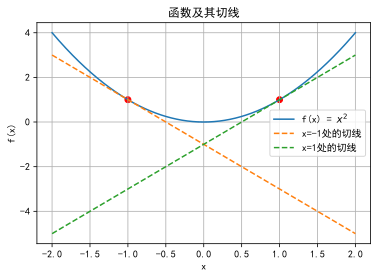

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# 设置matplotlib库可以显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 定义函数 f(x) = x^2
def f(x):
    return x**2

# 函数的导数 f'(x) = 2x
def df(x):
    return 2*x

# 定义切线 y = mx + b
def tangent_line(x, x0, y0):
    return df(x0) * (x - x0) + y0

# 生成x值
x = np.linspace(-2, 2, 400)

# 选择两个点
x1, x2 = -1, 1
y1, y2 = f(x1), f(x2)

# 绘制 f(x) 和切线
plt.figure(figsize=(6,4))
plt.plot(x, f(x), label='f(x) = $x^2$')
plt.plot(x, tangent_line(x, x1, y1), '--', label='x=-1处的切线')
plt.plot(x, tangent_line(x, x2, y2), '--', label='x=1处的切线')
plt.scatter([x1, x2], [y1, y2], color='red')  # 标记点
plt.title('函数及其切线')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


- **（3）公式11.2.11到公式11.2.12的推导过程**
  - 首先，从公式11.2.11出发：
$\frac{x-a}{b-a}f(b) + \frac{b-x}{b-a}f(a) \geq f(x)$
为了得到公式 $ (11.2.12) $，需要将 $ x $ 表达为 $ a $ 和 $ b $ 的线性组合。
  - 令：$$x = (1-\lambda)a + \lambda b$$其中 $ \lambda $ 是一个在 [0, 1] 之间的实数。
  - 将这个关于 $ x $ 的表达式代入公式 $ (11.2.11) $，得到：
$$ \frac{(1-\lambda)a + \lambda b-a}{b-a}f(b) + \frac{b-(1-\lambda)a - \lambda b}{b-a}f(a) \geq f((1-\lambda)a + \lambda b) $$
  - 简化上述不等式的左边部分：
    - 第一项：  
$$\frac{(1-\lambda)a + \lambda b-a}{b-a} = \frac{\lambda(b-a)}{b-a} = \lambda $$
    - 第二项：  
$$ \frac{b-(1-\lambda)a - \lambda b}{b-a} = \frac{b-a-\lambda(b-a)}{b-a} = 1-\lambda $$
  - 代入上述结果得到：
$$\lambda f(b) + (1-\lambda) f(a) \geq f((1-\lambda)a + \lambda b)$$
这正是公式11.2.12。

- **（4）$\nabla^2f \succeq 0$的涵义及其用途**
  - 符号 $\nabla^2f$ 表示函数 $f$ 的Hessian矩阵，而符号 $\succeq 0$ 表示一个矩阵是半正定的。所以，$\nabla^2f \succeq 0$ 表示函数 $f$ 的Hessian矩阵是半正定的。
  - **Hessian矩阵**:
    - Hessian矩阵是一个多元函数的所有二阶偏导数组成的矩阵。具体来说，对于一个定义在 $\mathbb{R}^n$ 上的函数 $f: \mathbb{R}^n \rightarrow \mathbb{R}$，其Hessian矩阵 $H$ 在点 $x$ 处的定义为：
$$
H_{ij}(x) = \frac{\partial^2 f}{\partial x_i \partial x_j}(x)
$$
    - 其中 $i,j = 1, \dots, n$.
  - **半正定矩阵**:
如果对于所有非零向量 $x$，都有 $x^\top H x \geq 0$，那么矩阵 $H$ 是半正定的。这基本上意味着，无论从哪个方向观察，函数的曲率都是非负的。
  - **用途**:
    - **判断函数的凸性**: 如果一个多元函数的Hessian矩阵在其定义域上是半正定的，那么该函数是凸的。这是因为在任何方向上，函数都不会有"下凹"的部分。
    - **优化问题**: 在优化领域，知道函数是凸的可以极大地简化问题，因为凸函数的任何局部最小值也是全局最小值。这意味着，当我们找到一个局部最小值时，我们知道它是全局的，所以搜索可以停止。
    - **数值稳定性**: 对于凸优化问题，存在众多的算法（如梯度下降、牛顿法等）能够保证收敛到全局最小值，而不仅仅是某个局部最小值。
  - **$\mathbf{H} \succeq 0$是函数凸性的充要条件。**
    - **数学推导**：
      - 从泰勒展开式看：
      $f(y) = f(x) + \nabla f(x)^T(y-x) + \frac{1}{2}(y-x)^T H(z)(y-x)$
      - 不等式条件$f(y) \geq f(x) + \nabla f(x)^T(y-x)$意味着：
        - 函数在任意点x处的切线（一阶泰勒展开）始终在函数图像的下方。
        - 换句话说，函数图像总是位于其任意点处的切线上方，这是凸函数的一个重要几何特征。
      - 对比这两个式子，可以得出：$\frac{1}{2}(y-x)^T H(z)(y-x) \geq 0$
      - 这意味着Hessian矩阵H(z)是半正定的。
      - Hessian矩阵的半正定性正是函数凸性的充分必要条件。
    - **保证凸性**：
      - 如果一个函数是凸的，那么在任意两点之间的函数值都不会超过这两点的线性插值。
      - 这个不等式正好保证了这一点：任意点处的切线都是函数的支撑线（supporting line）。
      - 这样的性质确保了任意两点之间的函数图像都在这两点的连线下方。
    - **等价性**：
      - 这个条件不仅是凸性的必要条件，也是充分条件。
      - 如果一个函数满足这个不等式，那么它一定是凸函数。
      - 如果一个函数是凸的，它也一定满足这个不等式。

-----------

## 11.2.3 凸优化的约束

凸优化的一个很好的特性是能够让我们有效地处理**约束（constraints）**。
即它使我们能够解决以下形式的**约束优化（constrained optimization）** 问题：

$$\begin{aligned} \mathop{\mathrm{minimize~}}_{\mathbf{x}} & f(\mathbf{x}) \\
    \text{ subject to } & c_i(\mathbf{x}) \leq 0 \text{ for all } i \in \{1, \ldots, N\}.
\end{aligned} \tag{11.2.16}$$

这里$f$是目标函数，$c_i$是约束函数。
例如第一个约束$c_1(\mathbf{x}) = \|\mathbf{x}\|_2 - 1$，则参数$\mathbf{x}$被限制为单位球。
如果第二个约束$c_2(\mathbf{x}) = \mathbf{v}^\top \mathbf{x} + b$，那么这对应于**半空间**上所有的$\mathbf{x}$。
同时满足这两个约束等于选择一个球的切片作为约束集。

注：**半空间（half-space）** 是指一个由线性不等式描述的空间的一部分，在几何上是指由一个超平面将整个空间分隔成的两个区域之一。

### 11.2.3.1 拉格朗日函数

通常，求解一个有约束的优化问题是困难的，解决这个问题的一种方法来自物理中相当简单的直觉。
想象一个球在一个盒子里，球会滚到最低的地方，重力将与盒子两侧对球施加的力平衡。
简而言之，目标函数（即重力）的梯度将被约束函数的梯度所抵消（由于墙壁的“推回”作用，需要保持在盒子内）。
请注意，任何不起作用的约束（即球不接触壁）都将无法对球施加任何力。

这里我们简略拉格朗日函数$L$的推导，上述推理可以通过以下鞍点优化问题来表示：

$$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n) = f(\mathbf{x}) + \sum_{i=1}^n \alpha_i c_i(\mathbf{x}) \text{ where } \alpha_i \geq 0 \tag{11.2.17}$$

这里的变量$\alpha_i$（$i=1,\ldots,n$）是所谓的**拉格朗日乘数（Lagrange multipliers）**，它确保约束被正确地执行。
选择它们的大小足以确保所有$i$的$c_i(\mathbf{x}) \leq 0$。
例如，对于$c_i(\mathbf{x}) < 0$中任意$\mathbf{x}$，我们最终会选择$\alpha_i = 0$。
此外，这是一个**鞍点（saddlepoint）** 优化问题。
在这个问题中，我们想要使$L$相对于$\alpha_i$**最大化（maximize）**，同时使它相对于$\mathbf{x}$**最小化（minimize）**。
有大量的文献解释如何得出函数$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n)$。
我们这里只需要知道 **$L$的鞍点是原始约束优化问题的最优解** 就足够了。

--------------
- **说明：拉格朗日函数与拉格朗日乘数原理及其应用**
  - 在优化问题中，我们经常遇到需要在某些约束条件下找到某个函数的最小值或最大值的情境。
    - 拉格朗日乘数法是一种找到这些约束下的最优值的方法。
  - 考虑以下约束优化问题：
$$
\text{minimize } f(\mathbf{x})
$$
$$
\text{subject to } g_i(\mathbf{x}) = 0 \text{ for } i = 1, \ldots, m 
$$
    其中 $f: \mathbb{R}^n \rightarrow \mathbb{R}$是我们想要最小化的目标函数，而 $g_i(\mathbf{x})$ 是约束函数。
  - **拉格朗日函数**定义为：
$$
L(\mathbf{x}, \boldsymbol{\lambda}) = f(\mathbf{x}) + \sum_{i=1}^m \lambda_i g_i(\mathbf{x}) 
$$
  其中 $\boldsymbol{\lambda}$是**拉格朗日乘数向量**。
  - 拉格朗日函数和拉格朗日乘数是约束优化问题的核心概念。
    - 其提供了一种方法，可以**将带约束的问题转换成无约束的问题**，从而利用无约束优化方法来求解。  
  - **拉格朗日乘数 (Lagrange Multipliers)**  
    - 拉格朗日乘数 $\lambda_i$ 对应于每个约束条件$g_i(\mathbf{x}) \leq 0$。
      - 其作用是确保在优化过程中约束条件得到满足。
      - 直观地说，每个$\lambda_i$ 表示约束$g_i$ 对目标函数值的“影响”。如果$\lambda_i > 0$，则约束 $g_i$ 是“活跃”的，意味着它在当前的解 $\mathbf{x}^*$ 中是约束的。
    - 为了求解上述的约束优化问题，拉格朗日乘数法的核心思想是寻找一个解$\mathbf{x}^*$ 和一组拉格朗日乘数$\boldsymbol{\lambda}^*$ 使得拉格朗日函数$L(\mathbf{x}, \boldsymbol{\lambda})$ 相对于$\mathbf{x}$ 取得最小值，同时相对于$\boldsymbol{\lambda}$ 取得最大值，且满足 $\lambda_i \geq 0$。
  - 拉格朗日函数和拉格朗日乘数提供了一种方法来处理约束优化问题。通过结合目标函数和约束条件，我们可以将问题转化为在更广泛的搜索空间中求解的无约束问题。
  - 关键思想是：如果 $\mathbf{x^*}$ 是问题的解，那么存在 $\boldsymbol{\lambda^*}$使得 $ \nabla L(\mathbf{x^*}, \boldsymbol{\lambda^*}) = 0 $。
  - 简要概括：
    - 拉格朗日乘数法提供了一种处理约束优化问题的方法。
    - 通过引入拉格朗日乘数，我们将约束问题转化为无约束问题，然后求解拉格朗日函数的梯度为零的点。
    - 虽然在此示例中我们没有得到正确的答案，但这种方法在实际应用中是非常有效的。
  - **举例：**
    - 考虑以下问题：
$$
\text{minimize } f(x, y) = x^2 + y^2
$$
$$ 
\text{subject to } g(x, y) = x + y - 1 = 0
$$
    - 这是在直线 $x + y = 1$ 上找到距离原点最近的点的问题。
    - 可以使用拉格朗日乘数法来求解它。

In [7]:
## 使用线性代数函数求解
import numpy as np

# 定义方程组
def equations(vars):
    x, y, lmbda = vars
    eq1 = 2*x + lmbda
    eq2 = 2*y + lmbda
    eq3 = x + y - 1
    return [eq1, eq2, eq3]

# 使用 numpy 的线性代数函数求解
x, y, lmbda = np.linalg.solve([[2, 0, 1], [0, 2, 1], [1, 1, 0]], [0, 0, 1])

print(f"Optimal x: {x}, Optimal y: {y}, Objective value: {x**2 + y**2}")


Optimal x: 0.5, Optimal y: 0.5, Objective value: 0.5


In [4]:
lmbda

-1.0

In [8]:
## 使用scipy的optimize进行求解
import numpy as np
from scipy.optimize import minimize

# 目标函数
def objective(vars):
    x, y = vars
    return x**2 + y**2

# 约束
def constraint(vars):
    x, y = vars
    return x + y - 1

# 定义约束条件
con = {'type': 'eq', 'fun': constraint}

# 初始猜测
initial_guess = [0.0, 0.0]

# 进行优化
result = minimize(objective, initial_guess, constraints=con)

print(f"Optimal x: {result.x[0]}, Optimal y: {result.x[1]}, Objective value: {objective(result.x)}")


Optimal x: 0.5000000000000001, Optimal y: 0.4999999999999999, Objective value: 0.5


------------

### 11.2.3.2 惩罚

一种至少近似地满足约束优化问题的方法是采用拉格朗日函数$L$。**除了满足$c_i(\mathbf{x}) \leq 0$之外，我们只需将$\alpha_i c_i(\mathbf{x})$添加到目标函数$f(x)$。
这样可以确保不会严重违反约束。**

事实上，我们一直在使用这个技巧。
比如权重衰减4.5节，在目标函数中加入$\frac{\lambda}{2} |\mathbf{w}|^2$，以确保$\mathbf{w}$不会增长太大。
使用约束优化的观点，我们可以看到，对于若干半径$r$，这将确保$|\mathbf{w}|^2 - r^2 \leq 0$。
通过调整$\lambda$的值，我们可以改变$\mathbf{w}$的大小。

通常，添加惩罚是确保近似满足约束的一种好方法。
在实践中，这被证明比精确的满意度更可靠。
此外，对于非凸问题，许多使精确方法在凸情况下的性质（例如，可求最优解）不再成立。

--------------
- **说明：何为近似满足约束？如何通过惩罚来近似满足约束？**
  - 近似满足约束是指，我们**不严格**地满足某个约束，但确保违反该约束的程度是有限的或可以接受的。在优化问题中，完全满足所有约束可能会非常困难，尤其是在非线性、非凸或高维问题中。因此，近似满足约束提供了一种实际的、在许多应用中有效的方法。
  - 使用惩罚来近似满足约束的基本思想是在目标函数中添加一个与违反约束程度成正比的项，这通常被称为惩罚项。这样，当解违反约束时，其代价或目标函数的值会增加，使得这样的解不那么有吸引力。
  - 以下是使用惩罚来近似满足约束的详细步骤：
    - **定义约束**:   首先，需要明确定义问题的约束。例如，考虑以下约束优化问题：
$$
\begin{aligned}
\text{minimize } & f(\mathbf{x}) \\
\text{subject to } & c_i(\mathbf{x}) \leq 0, \quad i = 1, \ldots, m
\end{aligned}
$$
    这里，$f(\mathbf{x})$ 是目标函数，$c_i(\mathbf{x})$ 是约束函数。
    - **选择惩罚函数**:   选择一个适当的惩罚函数$P(\cdot)$。这个函数通常**在其参数为非负时取正值，并在参数为负时取0**。常见的选择有二次惩罚函数和线性惩罚函数。
    - **构造带有惩罚项的优化问题**:
   通过将原始目标函数和所有约束的惩罚项结合，构造一个新的优化问题。这个问题的形式如下：
$$
\text{minimize } f(\mathbf{x}) + \sum_{i=1}^m \alpha_i P(c_i(\mathbf{x}))
$$
  其中，$\alpha_i$ 是一个非负的惩罚系数，表示对第i个约束的违反程度的惩罚强度。
    - **求解新的优化问题**:
   由于新的问题是一个无约束问题，我们可以使用各种标准的优化方法来求解它，如梯度下降、牛顿法等。
    - **调整惩罚系数**:
   如果得到的解仍然不满意或违反约束的程度过大，可以增加惩罚系数$\alpha_i$，然后重新求解问题。这个过程可以迭代进行，直到得到满意的结果。
  - 通过这种方法，即使解可能不严格满足所有约束，但由于惩罚的存在，解通常会非常接近于满足所有约束。
  - 这种方法在实践中被证明是非常有效的，尤其是在处理复杂的、难以满足所有约束的问题时。


- **示例：**
  - 考虑以下优化问题：
    - 目标：最小化$f(\mathbf{x}) = x_1^2 + x_2^2 + x_1 x_2$
    - 约束：
      - $x_1 + x_2 \geq 1$
      - $x_1^2 + x_2^2 \leq 2$
  - 可以使用二次惩罚方法来近似满足这些约束。
  - 这意味着我们将为每个约束添加一个惩罚项，该惩罚项在违反约束时会增大。
  - 惩罚后的优化问题为：
$$
\text{minimize } f(\mathbf{x}) + \alpha_1 \max(0, -(x_1 + x_2 - 1))^2 + \alpha_2 \max(0, x_1^2 + x_2^2 - 2)^2
$$
其中，$\alpha_1$ 和 $\alpha_2$ 是正的惩罚系数。
  - 图示：

 <img src='../img/11_2_2.png' width=400px/>

In [9]:
import numpy as np

def objective(x, alpha1, alpha2):
    # 主要目标函数
    main_obj = x[0]**2 + x[1]**2 + x[0]*x[1]
    
    # 约束的惩罚项
    penalty1 = alpha1 * np.maximum(0, -(x[0] + x[1] - 1))**2
    penalty2 = alpha2 * np.maximum(0, x[0]**2 + x[1]**2 - 2)**2
    return main_obj + penalty1 + penalty2

def gradient(x, alpha1, alpha2):
    # 主要目标函数的梯度
    grad_main = np.array([2*x[0] + x[1], 2*x[1] + x[0]])
    
    # 约束的惩罚项的梯度
    grad_penalty1 = np.array([
        -2*alpha1*np.maximum(0, -(x[0] + x[1] - 1)),
        -2*alpha1*np.maximum(0, -(x[0] + x[1] - 1))
    ])
    grad_penalty2 = np.array([
        2*alpha2*x[0]*np.maximum(0, x[0]**2 + x[1]**2 - 2),
        2*alpha2*x[1]*np.maximum(0, x[0]**2 + x[1]**2 - 2)
    ])
    
    return grad_main + grad_penalty1 + grad_penalty2

def gradient_descent(x_init, alpha1, alpha2, lr=0.01, max_iter=1000):
    x = x_init
    for _ in range(max_iter):
        grad = gradient(x, alpha1, alpha2)
        x = x - lr * grad
    return x

# 初始化参数
x_init = np.array([0., 0.])
alpha1 = 10
alpha2 = 10

# 执行梯度下降法
x_optimal = gradient_descent(x_init, alpha1, alpha2)
optimal_value = objective(x_optimal, alpha1, alpha2)

x_optimal, optimal_value

(array([0.46511628, 0.46511628]), 0.6976744186046511)

-------------

### 11.2.3.3 投影

满足约束条件的另一种策略是**投影（projections）**。
同样，我们之前也遇到过，例如在8.5节中处理梯度裁剪时，我们通过

$$\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, \theta/\|\mathbf{g}\|) \tag{11.2.18}$$

确保梯度的长度以$\theta$为界限。

这就是$\mathbf{g}$在半径为$\theta$的球上的**投影（projection）**。
更泛化地说，在凸集$\mathcal{X}$上的投影被定义为

$$\mathrm{Proj}_\mathcal{X}(\mathbf{x}) = \mathop{\mathrm{argmin}}_{\mathbf{x}' \in \mathcal{X}} \|\mathbf{x} - \mathbf{x}'\|  \tag{11.2.19}$$

它是$\mathcal{X}$中离$\mathbf{X}$最近的点。

<center><img src='../img/projections.svg'/></center>
<center>图11.2.4 Convex Projections</center><br>

投影的数学定义听起来可能有点抽象，为了解释得更清楚一些，请看 图11.2.4。
图中有两个凸集，一个圆和一个菱形。
两个集合内的点（黄色）在投影期间保持不变。
**两个集合（黑色）之外的点投影到集合中接近原始点（黑色）的点（红色）**。
虽然对于$L_2$的球面来说，方向保持不变，但一般情况下不需要这样。

凸投影的一个用途是计算稀疏权重向量。
在本例中，我们将权重向量投影到一个$L_1$的球上，
这是图11.2.4中菱形例子的一个广义版本。


## 小结

在深度学习的背景下，凸函数的主要目的是帮助我们详细了解优化算法。
我们由此得出梯度下降法和随机梯度下降法是如何相应推导出来的。

* 凸集的交集是凸的，并集不是。
* 根据詹森不等式，“一个多变量凸函数的总期望值”大于或等于“用每个变量的期望值计算这个函数的总值“。
* 一个二次可微函数是凸函数，当且仅当其Hessian（二阶导数矩阵）是半正定的。
* **凸约束可以通过拉格朗日函数来添加。在实践中，只需在目标函数中加上一个惩罚就可以了。**
* 投影映射到凸集中最接近原始点的点。